<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/Bollinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


ESTRATÉGIA
1. fechou fora-fechou dentro com o ultimo fechamento 3 tr da sma20, entra no rompimento de máxima / mínima do ultimo dia
2. stop no fundo/topo do ff-fd, saída se chegar na media 20 dos fechamentos



In [1]:
import pandas as pd
import numpy as np
import copy
import datetime

try:
  import yfinance as yf
except ImportError:
  !pip install -q  yfinance
  import yfinance as yf

try:
  import ta
except ImportError:
  !pip install -q  ta
  import ta

In [ ]:
def reset_data() :
  data=pd.read_csv(dir+'data/data.csv')
  data.set_index(data['Date'],inplace=True)
  data.drop(columns=['Date'],axis=1,inplace=True)
  data

In [ ]:
codigo = str(input('codigo ='))


In [6]:
periodo='max'

data = pd.DataFrame()
data = yf.download(tickers=codigo+'.SA' , period=periodo , progress = False  , auto_adjust=True)

bbol= ta.volatility.BollingerBands(close=data['Close'],window=20,window_dev=2)
tr  = ta.volatility.AverageTrueRange(high=data['High'],close=data['Close'],low=data['Low'],window=20)

data['l_bb'] = bbol.bollinger_lband()
data['bb_m'] = bbol.bollinger_mavg()
data['h_bb'] = bbol.bollinger_hband()
data['atr'] = tr.average_true_range()

data.dropna(inplace=True)
print(data[510:550].head())

m=len(data)

import os
dir=os.getcwd()
data.to_csv(dir+'/data/data.csv')

                Open      High       Low     Close   Volume      l_bb  \
Date                                                                    
2002-03-19  1.569295  1.581163  1.542920  1.581163   522900  1.308601   
2002-03-20  1.569295  1.648419  1.569295  1.648419   623700  1.327258   
2002-03-21  1.577207  1.622045  1.557426  1.569295  2694600  1.344638   
2002-03-22  1.531052  1.582482  1.531052  1.544239   999900  1.359148   
2002-03-25  1.544240  1.575889  1.529734  1.542921   800100  1.374345   

                bb_m      h_bb       atr  
Date                                      
2002-03-19  1.464192  1.619783  0.060249  
2002-03-20  1.481929  1.636600  0.061193  
2002-03-21  1.492545  1.640451  0.062683  
2002-03-22  1.500391  1.641634  0.062120  
2002-03-25  1.507842  1.641339  0.061322  


In [7]:
# Compra
signalB = np.where((data['Close'].shift(2) < data['l_bb'].shift(2))        #anteontem fechou fora
                  & (data['Close'].shift(1) > data['l_bb'].shift(1))       #ontem fechou dentro
                  & (np.abs(data['Close'] - data['bb_m']) > 3*data['atr']) # e fechou longe da média
                  & (data['Close'] >= np.maximum(data['Close'].shift(1),data['Close'].shift(2)) ) # hoje rompeu as maximas
                  , 1, 0)
# Venda descoberta
signalS = np.where((data['Close'].shift(2) > data['h_bb'].shift(2))          #anteontem fechou fora
                  & (data['Close'].shift(1) < data['h_bb'].shift(1))         #ontem fechou dentro
                  & (np.abs(data['Close'] - data['bb_m']) > 3*data['atr'])   # e fechou longe da média
                  & (data['Close'] <= np.minimum(data['Close'].shift(1),data['Close'].shift(2)) ) # hoje rompeu as maximas
                  , -1, 0)
data['signal'] = signalB + signalS

#stop

#saida
i=0
while (i < m -1 and data['signal'].iloc[i] == 0) : i+=1
j=i
while (j < m-1 and data['Close'].iloc[j] < data['bb_m'].iloc[j]  ) : j+=1
data.loc[data.index[i]:data.index[j],'signal'] = 1

i=0
while (i < m-1 and data['signal'].iloc[i] != -1) : i+=1
j=i
while (j < m-1 and data['Close'].iloc[j] > data['bb_m'].iloc[j]  ) : j+=1
data.loc[data.index[i]:data.index[j],'signal'] = -1


In [8]:
data['retrn'] =  np.log(data['Close']) - np.log(data['Close'].shift(1))
data['strategy_returns'] = data['retrn'] * (data['signal'].shift(1))

In [9]:
print("Strategy returns:",data['strategy_returns'].cumsum()[-1])


Strategy returns: -0.03858205410249438


/tmp/ipykernel_41369/1638026492.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Strategy returns:",data['strategy_returns'].cumsum()[-1])


In [10]:
print("Buy and hold returns:",data['retrn'].cumsum()[-1])


Buy and hold returns: 3.955045993574576


/tmp/ipykernel_41369/3938542185.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Buy and hold returns:",data['retrn'].cumsum()[-1])


In [11]:
data[data['signal']==-1]

,Open,High,Low,Close,Volume,l_bb,bb_m,h_bb,atr,signal,retrn,strategy_returns
Date,,,,,,,,,,,,
2003-11-25,2.967155,3.006717,2.938143,2.957924,1515600,2.344296,2.677692,3.011089,0.088082,-1,-0.003116,-0.000000
2003-11-26,3.000123,3.019904,2.967154,3.009354,742500,2.349762,2.702880,3.055998,0.086777,-1,0.017238,-0.017238
2003-11-27,3.005398,3.164965,2.981661,3.164965,1702800,2.333788,2.733211,3.132634,0.091603,-1,0.050417,-0.050417
2003-11-28,3.164966,3.283652,3.164966,3.230902,3353400,2.334302,2.770795,3.207288,0.092957,-1,0.020619,-0.020619
2003-12-01,3.232219,3.323212,3.164964,3.283650,2003400,2.328685,2.807060,3.285435,0.096222,-1,0.016194,-0.016194
2003-12-02,3.273101,3.303433,3.233540,3.257277,3078900,2.340971,2.842336,3.343702,0.094905,-1,-0.008064,0.008064
2003-12-03,3.246726,3.283651,3.212439,3.262551,2475000,2.365713,2.878536,3.391358,0.093721,-1,0.001618,-0.001618
2003-12-04,3.282333,3.282333,3.197934,3.197934,1302300,2.393572,2.908207,3.422843,0.093255,-1,-0.020004,0.020004
2003-12-05,3.204527,3.230901,3.124084,3.151777,2925900,2.435258,2.936890,3.438521,0.093933,-1,-0.014539,0.014539


In [12]:
data[data['signal']==1]

,Open,High,Low,Close,Volume,l_bb,bb_m,h_bb,atr,signal,retrn,strategy_returns
Date,,,,,,,,,,,,
2003-04-22,1.715675,1.755237,1.687981,1.714356,2822400,1.281526,1.520898,1.760269,0.060383,1,-0.009188,-0.0
2012-04-10,11.442840,11.637270,11.286349,11.490262,9410000,11.151537,12.692774,14.234011,0.367195,1,0.006210,0.0
2017-05-24,19.107216,19.617661,19.038237,19.038237,12103000,18.058741,21.874623,25.690505,0.933874,1,0.017544,0.0


In [15]:
df = data.copy()
df["Date"]=df.index

# feriados

inicio = df.index[0].strftime("%Y-%m-%d")
fim = df.index[-1].strftime("%Y-%m-%d")

url = 'https://raw.githubusercontent.com/BDonadelli/Codigos-em-financas/main/data/feriados.csv'

feriado = pd.read_csv(url)
feriado['Data'] =  pd.to_datetime(feriado['Data'], format='%d/%m/%Y')
feriado.set_index(feriado.Data, inplace=True)
feriado['Data'] = feriado['Data'].astype(str)
lista = feriado.Data.loc[inicio:fim].values

# feriados


import plotly
import cufflinks as cf # para conectar o plotly ao pandas
cf.go_offline()
plotly.offline.init_notebook_mode(connected = True)
import plotly.io as pio
pio.renderers.default = 'vscode'

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=3, cols=1,
                          #shared_xaxes=True,
                          vertical_spacing=0.05,
                          subplot_titles=(codigo, 'sinal C/V', 'ATR'),
                          row_width=[0.1, 0.2, 0.4])

fig.append_trace({ 'x': df.Date,
           'open': df.Open,
           'close': df.Close,
           'high': df.High,
           'low': df.Low,
           'type': 'candlestick',
           'name': codigo,
           'showlegend': True }
, row=1, col=1 )

fig.append_trace(go.Scatter( name="sma20",
                 line=dict(color='lightblue'),
    x=df.index,
    y=df.bb_m,
), row=1, col=1)

fig.append_trace(go.Scatter( name="sma20 + 2dp",
                 line=dict(color='lightgreen'),
    x=df.index,
    y=df.h_bb,
), row=1, col=1 )

fig.append_trace(go.Scatter( name="sma20 - 2dp",
                 line=dict(color='lightgreen'),
    x=df.index,
    y=df.l_bb,
), row=1, col=1)

fig.append_trace(go.Scatter( name="sinal C/V",
    x = df.Date,
    y = df.atr,
), row=3, col=1)

fig.append_trace(go.Scatter( name="sinal C/V",
    x = df.Date,
    y = df.signal,
), row=2, col=1)

fig.update_xaxes(
        rangeslider_visible=False,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            #dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            dict(values=lista)#["2018-12-24","2019-12-24", "2020-12-24", "2021-12-24", "2022-12-24"]) ,
            #dict(values=["2018-12-25","2019-12-25", "2020-12-25", "2021-12-24", "2022-12-24"]) ,
            #dict(values=["2018-01-01","2019-01-01", "2020-01-01", "2021-01-01", "2022-01-01"])
        ]
    )

fig.update_layout(height=900, width=1200)

fig.show()


In [ ]:
!pip install gitly -q


In [ ]:
from gitly.colab.plot import GitlyPlotter

# Instantiate the object using 'github' or 'git' for static plots
# or 'colab' for default dinamic Plotly plots
gitly = GitlyPlotter('github')
##
#https://github.com/Tiagoeem/gitly/blob/master/examples/Using_Gitly_Example.ipynb
##

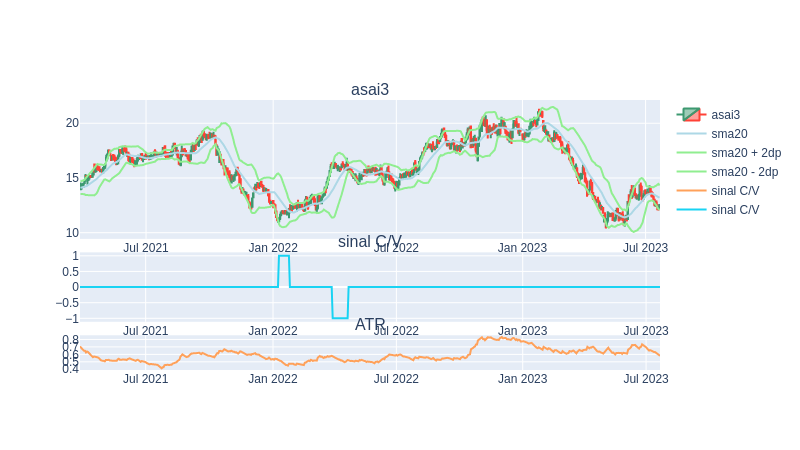

In [ ]:
gitly.show( fig )

<Axes: xlabel='Date'>

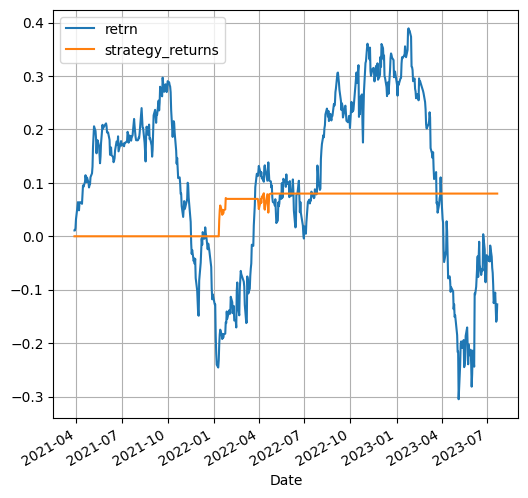

In [ ]:
# plotting strategy historical performance over time
df[['retrn','strategy_returns']] = data[['retrn','strategy_returns']].cumsum()
df[['retrn','strategy_returns']].plot(grid=True, figsize=(6, 6))


In [ ]:
# try:
#   import mplfinance as mpl
# except ImportError:
#   !pip install -q  mplfinance
#   import mplfinance as mpl

# dados = data['2022':].copy()

# plot_bbol_m = mpl.make_addplot(dados['bb_m'])
# plot_bbol_h = mpl.make_addplot(dados['h_bb'])
# plot_bbol_l = mpl.make_addplot(dados['l_bb'])
# plot_bbol_atr = mpl.make_addplot(dados['atr'],panel=1, ylabel='ATR(20)')


# mpl.plot(dados,type='candle',style="charles",figsize=(14,5), addplot=[plot_bbol_m,plot_bbol_h,plot_bbol_l,plot_bbol_atr])#,volume=True)

In [ ]:
# ## substitui pela biblioteca ta

# def tr(df, n=20):
#   dd = df.copy()
#   dd['high_low']   = dd['High'] - dd['Low']
#   dd['high_close'] = np.abs(dd['High'] - dd['Close'].shift(1))
#   dd['low_close']  = np.abs(dd['Low'] - dd['Close'].shift(1))
#   dd['tr']  = dd[['high_low', 'high_close', 'low_close']].max(axis=1)

#   sma = dd['tr'].rolling(window=n, min_periods=n).mean()[:n]
#   dd['tr'] = pd.concat([sma , dd['tr'][n:]]).ewm(alpha=1/n, adjust=False).mean()

#   return dd['tr']

# def bollinger_bands(df,n=20,dp=2):
#   dd = pd.DataFrame(df['Close'])
#   dd['stdev'] = dd['Close'].rolling(window=n).std()
#   dd['sma']   = dd['Close'].rolling(window=n).mean()
#   dd['upbb']  = dd['sma']+dp*dd['stdev']
#   dd['lobb']  = dd['sma']-dp*dd['stdev']

#   return dd[['lobb' , 'sma' , 'upbb' ]]

# dt = pd.DataFrame({
#   "Array_1": [49,0, 70 ,0,0,0,0,0,1,1,1,1,0,0,0,0,-1,-1,-1,-1,-1],
# })

# print(dt.replace(to_replace=0, method='ffill') )#.replace(49.50, 60))